In [1]:
from math import sqrt
import numpy as np

from funcoesTermosol import plota, importa, geraSaida
from auxiliar import insert, gauss_seidel
import solver
from solver import Node, Element, System

In [2]:
# gera saida 
# R -> matriz com as restrições 

nn,N,nm,Inc,nc,F,nr,R = importa("entrada.xlsx")

In [3]:
system = System(debug=True)

### Adição de nós ao sistema

In [4]:
for x, y in N.T:
    system.add_node(x, y)

[SYS] created node: ○ 1 (0.0, 0.0)
[SYS] created node: ○ 2 (1.0, 0.0)
[SYS] created node: ○ 3 (2.0, 0.0)
[SYS] created node: ○ 4 (3.0, 0.0)
[SYS] created node: ○ 5 (4.0, 0.0)
[SYS] created node: ○ 6 (3.0, 1.0)
[SYS] created node: ○ 7 (2.0, 2.0)
[SYS] created node: ○ 8 (1.0, 1.0)
[SYS] created node: ○ 9 (2.0, 1.0)


### Adição de elementos ao sitema

In [5]:
for n1, n2, elasticity, area in Inc:
    # .define_element recebe os dois nós entre os quais se define o elemento
    system.define_element(int(n1), int(n2), elasticity, area)

[SYS] created element: 1 ○--(1)--○ 2; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 2 ○--(2)--○ 3; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 3 ○--(3)--○ 4; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 4 ○--(4)--○ 5; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 5 ○--(5)--○ 6; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 6 ○--(6)--○ 7; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 7 ○--(7)--○ 8; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 8 ○--(8)--○ 1; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 2 ○--(9)--○ 8; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 2 ○--(10)--○ 9; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 3 ○--(11)--○ 9; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 9 ○--(12)--○ 4; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element: 4 ○--(13)--○ 6; E = 210000000000.0 Pa; A = 0.0225 m²
[SYS] created element

In [28]:
print("Matriz de nós:")
print(system.N)

Matriz de nós:
[[0. 1. 2. 3. 4. 3. 2. 1. 2.]
 [0. 0. 0. 0. 0. 1. 2. 1. 1.]]


In [29]:
print("Matriz de conectividade:")
print(system.C.T)

Matriz de conectividade:
[[-1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1 -1  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0]
 [ 0  1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  1 -1  0  0  0  0  0  0  0  1 -1  0  0  0]
 [ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 -1  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1 -1  1  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  1  1 -1  0 -1  1 -1]]


In [8]:
CONSTRAINTS = R
for node, direction in CONSTRAINTS:
    system.add_constraint(node, direction)

Constraint x added to node 1
Constraint y added to node 1
Constraint y added to node 2
Constraint y added to node 3
Constraint y added to node 4
Constraint x added to node 5
Constraint y added to node 5


In [9]:
# R, strain, U = system.solve(F)
r_linalg, s_linalg, u_linalg = system.solve(F, solver="linalg")

[SYS] Strategy used in solution: linalg.solve


In [10]:
# Reacoes de apoio [N]
print(r_linalg)

[[  -742.73314315]
 [  -476.36585747]
 [     0.        ]
 [  2034.52283151]
 [     0.        ]
 [  3345.74766053]
 [     0.        ]
 [  3110.39961429]
 [ -3257.26685685]
 [  1985.69575114]
 [     0.        ]
 [     0.        ]
 [  2000.        ]
 [-10000.        ]
 [  2000.        ]
 [     0.        ]
 [     0.        ]
 [     0.        ]]


In [11]:
# R, strain, U = system.solve(F)
r_gauss, s_gauss, u_gauss = system.solve(F, 'gauss', tolerance=1e-8, max_iterations=1000)

[SYS] Strategy used in solution: Gauss-Seidel| Max Iterations: 1000 Tolerance: 1e-08
Tolerance reached in 87 iterations with relative diff 8.685674401931465e-09


In [12]:
# Reacoes de apoio [N]
print(r_gauss)

[[  -742.73314313]
 [  -476.36585747]
 [     0.        ]
 [  2034.52283151]
 [     0.        ]
 [  3345.74766053]
 [     0.        ]
 [  3110.3996143 ]
 [ -3257.26685685]
 [  1985.69575113]
 [     0.        ]
 [     0.        ]
 [  2000.        ]
 [-10000.        ]
 [  2000.        ]
 [     0.        ]
 [     0.        ]
 [     0.        ]]


### Comparação entre Gauss-Seidel e np.linalg.solve

- Soma absoluta dos erros dos deslocamentos

In [13]:
np.sum(np.abs(u_linalg - u_gauss))

1.7030934128417594e-17

- Soma absoluta dos erros das reações

In [14]:
np.sum(np.abs(r_linalg - r_gauss))

3.781156010518316e-08

- Soma absoluta dos erros das tensões

In [15]:
np.sum(np.abs(s_linalg - s_gauss))

9.457612547016895e-18

In [16]:
R = r_gauss.copy()
U = u_gauss.copy()
strain = s_gauss.copy()

In [17]:
# Deslocamento [m]
U

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 5.63740287e-08],
       [ 0.00000000e+00],
       [ 1.62744803e-07],
       [ 0.00000000e+00],
       [ 2.69115578e-07],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 9.05855900e-07],
       [-2.82799280e-07],
       [ 1.33551493e-06],
       [-1.84167258e-06],
       [ 6.65746946e-07],
       [-3.80590097e-07],
       [ 6.23056619e-07],
       [-7.08094743e-07]])

In [18]:
# desformaçao [adimensional]
strain

array([[ 5.63740287e-08],
       [ 1.06370775e-07],
       [ 1.06370775e-07],
       [-2.69115578e-07],
       [-5.94327590e-07],
       [-9.94266167e-07],
       [-3.95657252e-07],
       [ 1.42578425e-07],
       [-3.80590097e-07],
       [-7.07060761e-08],
       [-7.08094743e-07],
       [-5.31017892e-07],
       [-2.82799280e-07],
       [ 2.82799280e-07],
       [-4.26903265e-08],
       [-1.13357784e-06]])

In [19]:
# Tensoes internas [Pa]
stress_element = np.array([[el.E] for el in system._elements])*strain
stress_element

array([[  11838.54602971],
       [  22337.86266761],
       [  22337.86266769],
       [ -56514.271365  ],
       [-124808.7938666 ],
       [-208795.89511491],
       [ -83088.02290405],
       [  29941.46916801],
       [ -79923.92031823],
       [ -14848.27598472],
       [-148699.89602354],
       [-111513.75737118],
       [ -59387.84882481],
       [  59387.84882459],
       [  -8964.96857044],
       [-238051.34669401]])

In [20]:
# Forças internas [N]
Fi = np.array([[el.A] for el in system._elements])*stress_element
Fi

array([[  266.36728567],
       [  502.60191002],
       [  502.60191002],
       [-1271.57110571],
       [-2808.197862  ],
       [-4697.90764009],
       [-1869.48051534],
       [  673.68305628],
       [-1798.28820716],
       [ -334.08620966],
       [-3345.74766053],
       [-2509.05954085],
       [-1336.22659856],
       [ 1336.22659855],
       [ -201.71179283],
       [-5356.15530062]])

####  Gráfico de saída 

In [21]:
# geraSaida(nome,Ft,Ut,Epsi,Fi,Ti)
geraSaida("saida", R, U, strain, Fi, stress_element)

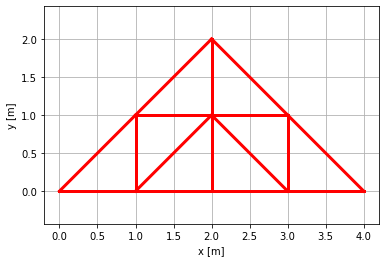

In [22]:
# plotar o grafico de entrada e de saida 
# def plota(N,Inc)

# ENTRADA 
plota(N, Inc)

In [23]:
n = system.nodes.astype("float64")

In [24]:
new_n = n.copy()

In [25]:
new_n = (n.T.reshape(U.shape) +( U*2e5)).reshape(n.T.shape).T

In [26]:
new_n

array([[0.        , 1.01127481, 2.03254896, 3.05382312, 4.        ,
        3.18117118, 2.26710299, 1.13314939, 2.12461132],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.94344014, 1.63166548, 0.92388198, 0.85838105]])

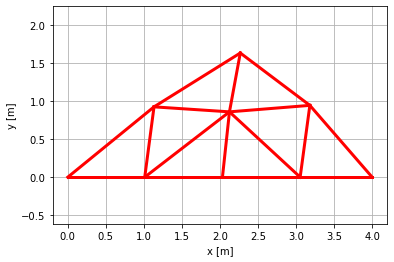

In [27]:
plota(new_n, Inc)